In [1]:
from lyricsgenius import Genius
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\richa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from nltk.corpus import stopwords

Import songs

In [3]:
album_df = pd.read_csv('../data/supplementary_data_1.csv')

In [4]:
album_df = album_df.dropna(subset=['lyrics']).copy()

In [5]:
album_df['char_lyrics'] = album_df['lyrics'].apply(lambda x: len(x))

In [6]:
album_df = album_df[album_df['song_id'] != 2448969].copy()

In [7]:
album_df = album_df[album_df['album_name'] != 'Young Sweet Jones']

In [8]:
album_df = album_df.sort_values(['release_date', 'album_type']).drop_duplicates('lyrics').copy()

In [9]:
tfidf_vectorizer = TfidfVectorizer(stop_words=None)
count_vectorizer = CountVectorizer(stop_words=None)

In [10]:
X = count_vectorizer.fit_transform(album_df['lyrics'])

In [11]:
count_array = X.toarray()

In [12]:
index_to_word_dict = dict()
for key, value in count_vectorizer.vocabulary_.items():
    index_to_word_dict[value] = key

In [13]:
cols = []
for index in range(count_array.shape[1]):
    cols.append(index_to_word_dict.get(index))

count_df = pd.DataFrame(data=count_array, index=album_df['song_id'].values, columns=cols)

In [64]:
count_df.T.to_csv('../data/full_count_matrix_230717.csv')

Run stopword statistics

In [124]:
stopword_df = pd.read_csv('../data/supplementary_data_2.csv')

In [53]:
stopword_df = stopword_df.rename(columns={'Unnamed: 0':'token'}).copy()

In [54]:
stopword_df = stopword_df.set_index('token')

In [55]:
stopword_df['n_documents'] = (count_df != 0).sum(axis=0)

In [56]:
stopword_df = stopword_df.reset_index()

In [57]:
eng_stopwords = stopwords.words('english')

In [58]:
for stopword in eng_stopwords:
    if "'" in stopword:
        eng_stopwords.append(stopword.replace("'", ''))

In [59]:
stopword_df['eng_stopword'] = stopword_df['token'].isin(eng_stopwords)

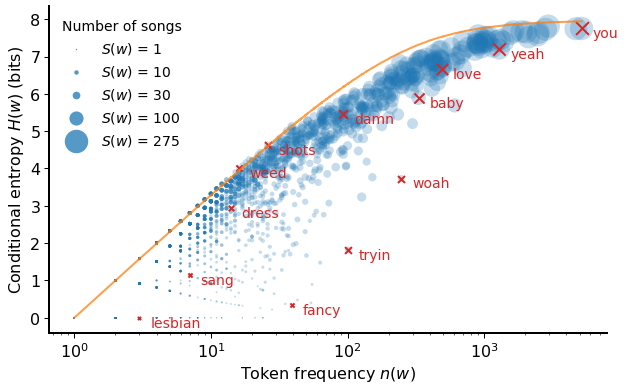

In [123]:
linewidth=2
fig = plt.figure(figsize=(10,6))
ax = plt.gca()
ax.scatter(stopword_df['N'], stopword_df['H'], s=2*stopword_df['n_documents'], linewidth=0, alpha=0.25)
ax.plot(stopword_df.sort_values('N')['N'], stopword_df.sort_values('N')['H-tilde'], 
        linewidth=linewidth, alpha=0.75, color=sns.color_palette()[1])
ax.set_xscale('log')
ax.set_ylabel('Conditional entropy $H(w)$ (bits)', fontsize=16)
ax.set_xlabel('Token frequency $n(w)$', fontsize=16)

ax.tick_params(labelsize=16, axis='both', width=linewidth/2, length=5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

[ax.spines[i].set_linewidth(linewidth) for i in ax.spines]

for size in [1,10,30,100,275]:
    ax.scatter([], [], s=2*size, color=sns.color_palette()[0],
               linewidth=0, label=r'$S(w)$ = ' + str(size), alpha=0.75)
leg = ax.legend(fontsize=14, frameon=False, loc='upper left')
leg.set_title('Number of songs')
plt.setp(leg.get_title(),fontsize=14)

priv_list = ['tryin', 'weed', 'you', 'yeah', 'love', 
             'baby', 'woah', 'damn', 'fancy', 
             'dress', 'lesbian', 'sang', 'shots']
priv_df = stopword_df[stopword_df['token'].isin(priv_list)]

for index, row in priv_df.iterrows():
    token = row['token']
    ax.scatter(row['N'], row['H'], s=10*np.sqrt(row['n_documents']), 
               linewidth=2, alpha=1, color=sns.color_palette()[3], 
               marker='x')
    ax.text(s=token, x=row['N']*1.2, y=row['H']+0.05, 
            color=sns.color_palette()[3], fontsize=14, va='top')
    
fig.savefig('../img/frequency_vs_i.png', dpi=200, bbox_inches='tight')

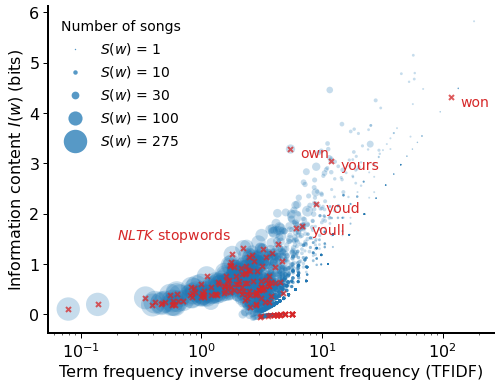

In [120]:
linewidth=2
fig = plt.figure(figsize=(8,6))
ax = plt.gca()

ax.scatter(stopword_df['tfidf'], stopword_df['I'], s=2*stopword_df['n_documents'], linewidth=0, alpha=0.25)
ax.set_xscale('log')

priv_list = ['own', 'yours', 'won', 'youd', 'youll']
priv_df = stopword_df[stopword_df['token'].isin(priv_list)]

ax.scatter(stopword_df[stopword_df['eng_stopword']]['tfidf'], 
           stopword_df[stopword_df['eng_stopword']]['I'], 
           s=25, marker='x',
           linewidth=2, alpha=0.75, color=sns.color_palette()[3], 
               )

for index, row in priv_df.iterrows():
    token = row['token']
    #ax.scatter(row['tfidf'], row['I'], s=10*np.sqrt(row['n_documents']), 
    #           linewidth=2, alpha=1, color=sns.color_palette()[3], 
    #           marker='x')
    ax.text(s=token, x=row['tfidf']*1.2, y=row['I']+0.05, 
            color=sns.color_palette()[3], fontsize=14, va='top')


for size in [1,10,30,100,275]:
    ax.scatter([], [], s=2*size, color=sns.color_palette()[0],
               linewidth=0, label=r'$S(w)$ = ' + str(size), alpha=0.75)
leg = ax.legend(fontsize=14, frameon=False, loc='upper left')
leg.set_title('Number of songs')
plt.setp(leg.get_title(),fontsize=14)

ax.set_ylabel('Information content $I(w)$ (bits)', fontsize=16)
ax.set_xlabel('Term frequency inverse document frequency (TFIDF)', fontsize=16)

ax.tick_params(labelsize=16, axis='both', width=linewidth/2, length=5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

[ax.spines[i].set_linewidth(linewidth) for i in ax.spines]
ax.text(s=r'$\it{NLTK}$ stopwords', x=0.2, y=1.5, fontsize=14, color=sns.color_palette()[3])

fig.savefig('../img/tfidf_vs_i.png', dpi=200, bbox_inches='tight')

In [88]:
stopword_df[stopword_df['eng_stopword']].sort_values('I')

,token,F,I,tfidf,H,H-tilde,H-tilde_std,N,n_documents,eng_stopword
2486,each,0.000094,-0.051925,3.051822,3.700440,3.648515,0.084922,13,13.0,True
7878,thatll,0.000087,-0.043689,3.131864,3.584963,3.541274,0.083207,12,12.0,True
197,against,0.000058,-0.032189,3.537330,3.000000,2.967811,0.088292,8,8.0,True
6180,re,0.000051,-0.024857,3.670861,2.807355,2.782498,0.083510,7,7.0,True
3165,further,0.000036,-0.015200,4.007333,2.321928,2.306728,0.076478,5,5.0,True
...,...,...,...,...,...,...,...,...,...,...
8890,youll,0.000378,1.759435,6.814701,3.738481,5.497916,0.082693,52,20.0,True
8889,youd,0.000247,2.191439,8.873616,2.764878,4.956317,0.080999,34,12.0,True
8899,yours,0.000487,3.045725,11.910014,2.760440,5.806166,0.081538,67,16.0,True
5500,own,0.000923,3.281773,5.480407,3.235834,6.517607,0.071960,127,43.0,True


In [106]:
stopword_df['I_pct'] = stopword_df['I'].rank(pct=True)*100

In [107]:
(stopword_df['I'] < 0).sum(), (stopword_df['I'] < 0).mean()

(2096, 0.23466188983430364)

In [108]:
def send_to_csv(df_slice, filename):
    df_slice[['token', 'I', 'I_pct', 'tfidf', 'N', 'n_documents', 'eng_stopword']].to_csv(filename, float_format='%.3f', index=False)
    return df_slice

In [109]:
send_to_csv(stopword_df.sort_values('I', ascending=False).head(25), '../data/top_information_tokens.csv')

,token,F,I,tfidf,H,H-tilde,H-tilde_std,N,n_documents,eng_stopword,I_pct
5926,preach,0.000538,5.821914,182.174085,0.103275,5.925189,0.078558,74,2.0,False,100.000000
6818,sexy,0.000392,5.146077,57.111436,0.397597,5.543674,0.078858,54,4.0,False,99.988804
2793,fancy,0.000283,4.791930,58.736065,0.343100,5.135030,0.082665,39,3.0,False,99.977609
524,ay,0.000313,4.779430,45.477625,0.475634,5.255064,0.082071,43,4.0,False,99.966413
526,aye,0.000400,4.672900,58.169055,0.894362,5.567262,0.081054,55,4.0,False,99.955217
2050,dedicate,0.000254,4.618492,52.711853,0.373140,4.991632,0.086048,35,3.0,False,99.944021
2921,fireworks,0.000174,4.491641,134.802506,0.000000,4.491641,0.081860,24,1.0,False,99.932826
8759,woop,0.000174,4.488569,134.802506,0.000000,4.488569,0.089815,24,1.0,False,99.921630
3187,gangstas,0.000174,4.486425,134.802506,0.000000,4.486425,0.084502,24,1.0,False,99.910434
8137,tri,0.000174,4.484862,134.802506,0.000000,4.484862,0.089127,24,1.0,False,99.899239


In [110]:
send_to_csv(stopword_df.sort_values('I', ascending=True).head(25), '../data/bottom_information_tokens.csv')

,token,F,I,tfidf,H,H-tilde,H-tilde_std,N,n_documents,eng_stopword,I_pct
6754,seem,0.000138,-0.073094,2.672332,4.247928,4.174833,0.083929,19,19.0,False,0.011196
8235,twice,0.000131,-0.067572,2.726399,4.169925,4.102353,0.084536,18,18.0,False,0.022391
6160,rapper,0.000124,-0.063989,2.783558,4.087463,4.023474,0.083390,17,17.0,False,0.033587
8592,weed,0.000116,-0.060377,2.844182,4.000000,3.939623,0.084286,16,16.0,False,0.044783
3168,future,0.000109,-0.058720,2.908721,3.906891,3.848171,0.085394,15,15.0,False,0.055979
2486,each,0.000094,-0.051925,3.051822,3.700440,3.648515,0.084922,13,13.0,True,0.067174
990,bread,0.000087,-0.047981,3.131864,3.584963,3.536981,0.087263,12,12.0,False,0.078370
4850,memphis,0.000094,-0.047771,3.051822,3.700440,3.652669,0.082733,13,13.0,False,0.089566
8274,uncle,0.000087,-0.047459,3.131864,3.584963,3.537503,0.084363,12,12.0,False,0.100761
7007,sitting,0.000087,-0.047148,3.131864,3.584963,3.537815,0.085185,12,12.0,False,0.111957


In [111]:
send_to_csv(stopword_df.sort_values('N', ascending=False).head(25), '../data/most_frequent_tokens.csv')

,token,F,I,tfidf,H,H-tilde,H-tilde_std,N,n_documents,eng_stopword,I_pct
8880,you,0.037555,0.192677,0.138152,7.751713,7.944390,0.008185,5167,273.0,True,75.358262
7880,the,0.034117,0.195894,0.587187,7.744501,7.940395,0.008260,4694,266.0,True,75.391850
8020,to,0.021412,0.100278,0.078768,7.813950,7.914228,0.010933,2946,273.0,True,74.048365
317,and,0.020438,0.181479,0.393057,7.729356,7.910835,0.011756,2812,265.0,True,74.921630
4811,me,0.018127,0.261296,0.577212,7.639540,7.900836,0.012863,2494,259.0,True,76.556202
4019,it,0.017880,0.322839,0.343855,7.577374,7.900213,0.012646,2460,265.0,True,77.966861
3875,im,0.015394,0.367342,0.662391,7.518972,7.886314,0.013584,2118,254.0,False,78.627407
5124,my,0.014704,0.227010,0.468204,7.653712,7.880722,0.014638,2023,259.0,True,75.918047
7874,that,0.013708,0.205136,0.466467,7.668970,7.874106,0.015005,1886,258.0,True,75.459024
3903,in,0.011869,0.185082,0.565990,7.671727,7.856809,0.016548,1633,252.0,True,74.977609


In [112]:
send_to_csv(stopword_df.sort_values('n_documents', ascending=False).head(25), '../data/most_songs_tokens.csv')

,token,F,I,tfidf,H,H-tilde,H-tilde_std,N,n_documents,eng_stopword,I_pct
8020,to,0.021412,0.100278,0.078768,7.813950,7.914228,0.010933,2946,273.0,True,74.048365
8880,you,0.037555,0.192677,0.138152,7.751713,7.944390,0.008185,5167,273.0,True,75.358262
7880,the,0.034117,0.195894,0.587187,7.744501,7.940395,0.008260,4694,266.0,True,75.391850
317,and,0.020438,0.181479,0.393057,7.729356,7.910835,0.011756,2812,265.0,True,74.921630
4019,it,0.017880,0.322839,0.343855,7.577374,7.900213,0.012646,2460,265.0,True,77.966861
4811,me,0.018127,0.261296,0.577212,7.639540,7.900836,0.012863,2494,259.0,True,76.556202
5124,my,0.014704,0.227010,0.468204,7.653712,7.880722,0.014638,2023,259.0,True,75.918047
7874,that,0.013708,0.205136,0.466467,7.668970,7.874106,0.015005,1886,258.0,True,75.459024
5382,on,0.011353,0.237240,0.411438,7.613182,7.850422,0.017090,1562,257.0,True,76.030004
3875,im,0.015394,0.367342,0.662391,7.518972,7.886314,0.013584,2118,254.0,False,78.627407


In [87]:
stopword_df[stopword_df['token'] == 'love']

,token,F,I,tfidf,H,H-tilde,H-tilde_std,N,n_documents,eng_stopword,I_pct
4600,love,0.003554,0.86012,1.941399,6.667645,7.527765,0.040065,489,151.0,False,88.647559


In [113]:
send_to_csv(stopword_df[stopword_df['eng_stopword']].sort_values('I', ascending=False).head(25), 
            '../data/informative_stopwords.csv')

,token,F,I,tfidf,H,H-tilde,H-tilde_std,N,n_documents,eng_stopword,I_pct
8747,won,0.000153,4.309681,117.952193,0.000000,4.309681,0.082941,21,1.0,True,99.854456
5500,own,0.000923,3.281773,5.480407,3.235834,6.517607,0.071960,127,43.0,True,99.540976
8899,yours,0.000487,3.045725,11.910014,2.760440,5.806166,0.081538,67,16.0,True,99.294671
8889,youd,0.000247,2.191439,8.873616,2.764878,4.956317,0.080999,34,12.0,True,98.231079
8890,youll,0.000378,1.759435,6.814701,3.738481,5.497916,0.082693,52,20.0,True,96.977161
8906,youve,0.000458,1.703198,6.042696,4.029866,5.733064,0.081108,63,25.0,True,96.865204
2305,doing,0.000385,1.384355,4.324358,4.136930,5.521284,0.077995,53,28.0,True,94.995522
8048,too,0.003016,1.309780,2.226541,6.137593,7.447373,0.044397,415,134.0,True,94.659651
8614,were,0.000923,1.289650,3.222470,5.228182,6.517832,0.070810,127,60.0,True,94.491715
195,again,0.000821,1.214762,3.852731,5.179266,6.394027,0.073795,113,50.0,True,94.223018


In [140]:
count_df['don'].sort_values().tail(30)

514         0
217750      0
58661       0
703734      0
214307      0
3033402     1
2463395     1
909         1
3028710     1
3886        1
2747        1
4183        1
4613586     1
3807730     1
151         1
3028711     1
3033405     1
503         1
139751      1
18050       2
3807744     2
58566       2
196551      2
2714        2
3033398     2
2992774     2
1842        2
50605       3
841         4
54906      10
Name: don, dtype: int64

In [143]:
album_df[album_df['song_id'] == 54906]['lyrics'].values

array([' I’m so fuckin dumb I wear diamonds on my thumbs There’s a diamond on my dick so there’s a diamond on her tongue I can’t feel you baby cause Im romantically numb Emotionally drained I came here just so I can come There’s nothing under Gods sun that I haven’t done I got a lot of problems, getting pussy just isn’t one Girls are like buses every 15 min they run Now they like potato chips I just can’t have one And I might like you for a minute But I don’t like your friends in my business And I feel like you don’t deserve a visit Cause you ain’t in the kitchen when you want a whipping  Uh, uh ahhhh I know you say you love me girl I know you say you love me girl Problem is you prol tell that shit to everybody So we hear you talking boo boo but we just don’t believe you  Uh, ok I’m all about it, all for it I’m all star team Jordan, small forward I’m never putting up a shot unless it calls for it No hesitation so I’m shooting if I draw for it Pow, Pow, fuck is up, naw man I’m in this h

In [149]:
stopword_df[(stopword_df['I_pct'] < 0.52) & (stopword_df['I_pct']>0.48)]

,token,F,I,tfidf,H,H-tilde,H-tilde_std,N,n_documents,eng_stopword,I_pct
4666,looked,0.000056,-0.032250,3.576550,3.000000,2.967750,0.086732,8,8.0,False,0.482933
5653,palm,0.000063,-0.032000,3.458767,3.169925,3.137925,0.079896,9,9.0,False,0.515860
7036,shits,0.000063,-0.032222,3.458767,3.169925,3.137703,0.083141,9,9.0,False,0.493908
7883,taken,0.000056,-0.032189,3.576550,3.000000,2.967811,0.088292,8,8.0,False,0.504884


In [190]:
stopword_df[stopword_df['N'] < 8].sort_values('N').tail(25)

,token,F,I,tfidf,H,H-tilde,H-tilde_std,N,n_documents,eng_stopword,I_pct
5011,miles,0.000049,1.117606,7.471971,1.664498,2.782104,0.083711,7,4.0,False,93.206015
5008,mil,0.000049,0.256857,4.508271,2.521641,2.778498,0.086094,7,6.0,False,76.127758
1845,cost,0.000049,-0.025251,3.710082,2.807355,2.782104,0.085639,7,7.0,False,1.053671
4704,lover,0.000049,0.258286,4.508271,2.521641,2.779926,0.086087,7,6.0,False,76.182636
1504,christmas,0.000049,-0.020571,3.710082,2.807355,2.786783,0.073854,7,7.0,False,1.821973
8293,treated,0.000049,0.257035,4.508271,2.521641,2.778676,0.089249,7,6.0,False,76.138733
3720,henny,0.000049,0.261714,4.508271,2.521641,2.783355,0.080277,7,6.0,False,76.484469
2755,excited,0.000049,-0.028501,3.710082,2.807355,2.778854,0.089604,7,7.0,False,0.768302
6769,sang,0.000049,1.633911,10.633886,1.148835,2.782746,0.085970,7,3.0,False,96.663374
8632,visit,0.000049,0.653733,5.665175,2.128085,2.781819,0.084111,7,5.0,False,84.721765


In [91]:
stopword_df[stopword_df['I'] < 0].sort_values('N')

,token,F,I,tfidf,H,H-tilde,H-tilde_std,N,n_documents,eng_stopword,I_pct
0,000,0.000015,-0.004000,4.923624,1.000000,0.996000,0.063119,2,2.0,False,17.840349
4917,millionaires,0.000015,-0.002000,4.923624,1.000000,0.998000,0.044677,2,2.0,False,21.775638
4911,milk,0.000015,-0.001000,4.923624,1.000000,0.999000,0.031607,2,2.0,False,23.068742
4900,mightve,0.000015,-0.001000,4.923624,1.000000,0.999000,0.031607,2,2.0,False,23.068742
4884,mexico,0.000015,-0.001000,4.923624,1.000000,0.999000,0.031607,2,2.0,False,23.068742
...,...,...,...,...,...,...,...,...,...,...,...
8235,twice,0.000131,-0.067572,2.726399,4.169925,4.102353,0.084536,18,18.0,False,0.022391
6754,seem,0.000138,-0.073094,2.672332,4.247928,4.174833,0.083929,19,19.0,False,0.011196
1636,comes,0.000167,-0.002766,2.640534,4.436605,4.433839,0.081626,23,22.0,False,20.868786
6910,shots,0.000189,-0.027719,2.493811,4.623517,4.595798,0.083755,26,25.0,False,0.817286


In [92]:
return_str = ''
for album in album_df['album_name'].unique():
    return_str = return_str + '\textit{'+ album +'}, '

In [93]:
return_str

'\textit{Honestly, Nevermind}, \textit{Certified Lover Boy}, \textit{Scary Hours 2}, \textit{Dark Lane Demo Tapes}, \textit{Care Package}, \textit{The Best in the World Pack}, \textit{Scorpion}, \textit{Scary Hours}, \textit{More Life}, \textit{Views}, \textit{If You’re Reading This It’s Too Late}, \textit{Nothing Was the Same}, \textit{Take Care}, \textit{Thank Me Later}, \textit{So Far Gone (EP)}, \textit{So Far Gone}, \textit{Comeback Season}, \textit{Room for Improvement}, \textit{Drake Demo Disk}, '

In [103]:
album_df

,album_name,album_id,song_id,song_name,release_date,album_type,lyrics,char_lyrics
298,Drake Demo Disk,516437,3351,City Is Mine,2006,EP,This the record that my backpack underground ...,3564
300,Drake Demo Disk,516437,4427020,Acapella,2006,EP,This the record that my backpack underground ...,3567
301,Drake Demo Disk,516437,18050,Do What You Do (Remix),2006,EP,"I do this for yall man Malice, Nickelus F, it...",4404
276,Room for Improvement,2625,333532,Intro (Room For Improvement),2006,Mixtape,"Yo, whats going on? This is Drake And Ima let...",935
277,Room for Improvement,2625,333538,Pianist Hands,2006,Mixtape,Thank you Ms. Graham for coming today. You loo...,857
...,...,...,...,...,...,...,...,...
9,"Honestly, Nevermind",880669,8110895,Overdrive,2022,Studio album,"Hold the line, we aint done Dont give up this...",1377
10,"Honestly, Nevermind",880669,8110896,Down Hill,2022,Studio album,"Baby, I think it might be too late, were too ...",1390
11,"Honestly, Nevermind",880669,8110898,Tie That Binds,2022,Studio album,"Oh, oh Oh, oh Oh, oh Kill me slowly with tho...",1315
12,"Honestly, Nevermind",880669,8110893,Liability,2022,Studio album,"You get in my bed, you twist up my head Im ch...",2085


In [106]:
stopword_df[stopword_df['token'] == 'houstatlantavegas']

,token,F,I,tfidf,H,H-tilde,H-tilde_std,N,n_documents,eng_stopword,I_pct
3786,houstatlantavegas,0.000153,4.310621,117.952193,0.0,4.310621,0.087546,21,1.0,False,99.865652


In [128]:
(stopword_df['N'] == 1).sum()

4463

In [159]:
stopword_df['N'].sort_values().tail(int(len(stopword_df)*0.05)).sum()/stopword_df['N'].sum()

0.7767707235527128

In [131]:
stopword_df['N'].sum()

137585

In [152]:
stopword_df['N']

0       2
1       1
2       4
3       5
4       5
       ..
8927    1
8928    1
8929    1
8930    1
8931    1
Name: N, Length: 8932, dtype: int64

In [115]:
len(album_df['album_name'].value_counts())

19

In [119]:
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

gini(stopword_df['N'].values)

0.8730457266810969

C:\Users\richa\anaconda3\envs\osint_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

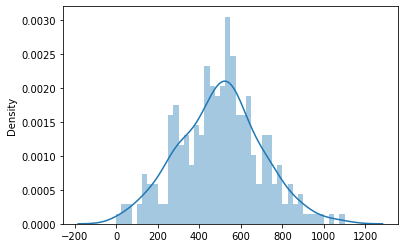

In [140]:
bins = np.arange(0,1200,25)
sns.distplot(count_df.sum(axis=1), bins)

In [135]:
count_df.sum(axis=1).median()

511.0

In [141]:
np.percentile(count_df.sum(axis=1), 5)

167.0

In [142]:
np.percentile(count_df.sum(axis=1), 95)

836.6

In [145]:
count_df.sum(axis=1).sort_values()

139751        9
372385       37
3033398      41
2463397      64
3028726      66
           ... 
196551      933
3100        961
4810        993
218330     1044
6555268    1090
Length: 275, dtype: int64

In [167]:
album_df[album_df['song_id'] == 2463404]['lyrics'].values

array([' Yeah, yeah Yeah, yeah Jheeze, yeah Right, look, look  Tell me how you really feel Tell me how you really feel I would ask you whats the deal But yall dont even got a deal Most niggas with a deal Couldnt make a greatest hits Yall a whole lot of things But you still aint this I dont know no one That could tell me what to do Heard you never claimed the hood Heard the hood claimed you That cant sit well Oh well, ship sailed Still mine, all mine Cosign, cosign I pull up in yachts so big That they try to hit me with boat fines Hype Williams, Big Pimpin, yeah Just like the old times Same niggas from the old days Lotta sides on the same side OVO, we a gold mine But Im goin gold, no time Doing plat, plat only Boys better back off me Hall of fame, hall of fame Like Im shirt off, like Im shirt off Like Im shirt off shorty Whole city goin crazy Whole city goin crazy Top five, no debatin Top five, top five, top five And the whole city rate me And Im back inside The Matrix And I said that w

In [147]:
album_df[album_df['song_id'] == 6555268]

,album_name,album_id,song_id,song_name,release_date,album_type,lyrics,char_lyrics
37,Scary Hours 2,742624,6555268,Lemon Pepper Freestyle,2021,EP,"Tryin, tryin, tryin, tryin I pray these nigga...",6198


In [165]:
count_df['won'].sort_values()

3351        0
3028711     0
3028708     0
3028702     0
3028710     0
           ..
55602       0
50895       0
58497       0
8110900     0
2463404    21
Name: won, Length: 275, dtype: int64

In [168]:
stopword_df

,token,F,I,tfidf,H,H-tilde,H-tilde_std,N,n_documents,eng_stopword,I_pct
0,000,0.000015,-0.004000,4.923624,1.000000,0.996000,0.063119,2,2.0,False,17.840349
1,05,0.000007,0.000000,5.616771,0.000000,0.000000,0.000000,1,1.0,False,48.454993
2,06,0.000029,-0.007000,4.230477,2.000000,1.993000,0.058745,4,4.0,False,11.957009
3,07,0.000036,-0.012000,4.007333,2.321928,2.309928,0.068235,5,5.0,False,6.129646
4,09,0.000036,-0.018302,4.007333,2.321928,2.303626,0.089631,5,5.0,False,2.787730
...,...,...,...,...,...,...,...,...,...,...,...
8927,zonin,0.000007,0.000000,5.616771,0.000000,0.000000,0.000000,1,1.0,False,48.454993
8928,zs,0.000007,0.000000,5.616771,0.000000,0.000000,0.000000,1,1.0,False,48.454993
8929,ándale,0.000007,0.000000,5.616771,0.000000,0.000000,0.000000,1,1.0,False,48.454993
8930,еasily,0.000007,0.000000,5.616771,0.000000,0.000000,0.000000,1,1.0,False,48.454993


In [99]:
count_df['won'].sort_values()

3351        0
3028711     0
3028708     0
3028702     0
3028710     0
           ..
55602       0
50895       0
58497       0
8110900     0
2463404    21
Name: won, Length: 275, dtype: int64

In [104]:
album_df[album_df['song_id'] == 218330]

,album_name,album_id,song_id,song_name,release_date,album_type,lyrics,char_lyrics
172,Nothing Was the Same,40475,218330,Pound Cake / Paris Morton Music 2,2013,Studio album,Good God Almighty—like back in the old days Y...,5634


In [114]:
count_df['fireworks'].sort_values()

3351        0
3028711     0
3028708     0
3028702     0
3028710     0
           ..
58340       0
55602       0
50895       0
58342       0
581        24
Name: fireworks, Length: 275, dtype: int64